In [1]:
# set work dir
import os
os.chdir("..")

In [2]:
from matplotlib import pyplot as plt
import scienceplots
import numpy as np
import pandas as pd
from types import SimpleNamespace
plt.style.reload_library()
plt.style.use("science")

In [3]:
def saveRadar(data_params, task_params, train_params, methods):
    # load data
    res_dir = getDir(data_params, task_params, train_params)
    res = pd.read_csv(res_dir + "/res.csv")
    # tasks
    optmodels = getOptModelName(data_params, task_params)
    # plot
    title = getTitle(data_params, task_params, train_params)
    filename = getFileName(data_params, task_params, train_params)
    plotPerfRadar(res, optmodels, methods, res_dir, title, filename)

In [4]:
def getDir(data_params, task_params, train_params):
    """
    Get dir to save figure and result
    """
    n = data_params["data"] # number of data
    p = data_params["feat"] # size of feature
    deg = data_params["deg"] # polynomial degree
    n_sp = task_params["n_sp"] # number of sp tasks
    n_tsp = task_params["n_tsp"] # number of tsp tasks
    algo = train_params["algo"] # training algo
    # results
    res_dir = "./res/{}sp{}tsp/{}/n{}p{}deg{}".format(n_sp, n_tsp, algo, n, p, deg)
    os.makedirs(res_dir, exist_ok=True)
    return res_dir

In [5]:
def getOptModelName(data_params, task_params):
    """
    Build optimization model for multiple task
    """
    m = data_params["node"] # number of nodes
    n_sp = task_params["n_sp"] # number of sp tasks
    n_tsp = task_params["n_tsp"] # number of tsp tasks
    # init optmodel list
    optmodels = []
    # shortest path
    for i in range(n_sp):
        optmodels.append("SP {}".format(i+1))
    # tsp
    for i in range(n_tsp):
        optmodels.append("TSP {}".format(i+1))
    return optmodels

In [6]:
def getTitle(data_params, task_params, train_params):
    """
    Get title of plot
    """
    if train_args["algo"] == "spo":
        title ="Learning from Costs\n"
    if train_args["algo"] == "pfyl":
        title ="Learning from Solutions\n"
    title += "{} Training Data, {} SP Tasks, {} TSP Tasks".format(data_args["data"], task_args["n_sp"], task_args["n_tsp"])
    return title

In [7]:
def getFileName(data_params, task_params, train_params):
    """
    Get file name save
    """
    filename = "radar_{}{}{}d{}".format(train_args["algo"], task_args["n_sp"], task_args["n_tsp"], data_args["data"])
    return filename

In [8]:
def plotPerfRadar(df, optmodels, methods, res_dir, title, filename):
    """
    Draw radar plot for performence
    """
    fig = plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    # data
    df = df.copy()
    for i in df.index:
        if type(df.at[i,"MSE"]) is str:
            df.at[i,"MSE"] = np.mean(eval(df.at[i,"MSE"]))
    # drop methods
    drops = []
    for i in df.index:
        if df.at[i,"Method"] not in methods:
            drops.append(i)
    df = df.drop(index=drops)
    # tol color
    colors = {"mse": "#332288", "separated":"#88ccee", "separated+mse":"#44aa99",
              "comb": "#117733", "comb+mse": "#999933", "gradnorm": "#ddcc77",
              "gradnorm+mse":"#cc6677", "scheduled": "#882255"}
    # categories
    categories = optmodels + ["MSE"]
    categories.append(categories[0])
    # label location
    label_loc = np.linspace(start=0, stop=2*np.pi, num=len(categories))
    # plot per method
    for i in df.index:
        mthd = df.at[i,"Method"]
        values = []
        # regret
        for task in optmodels:
            colname = "{} Avg Regret".format(task)
            regret = df.at[i,colname] / (np.ceil(df[colname].abs().max()*2)/2)
            values.append(regret)
        # mse
        mse = df.at[i,"MSE"] / (np.ceil(df["MSE"].abs().max()*2)/2)
        values.append(mse)
        # plot
        plt.plot(label_loc, values+[values[0]], label=mthd, lw=2, color=colors[mthd])
        plt.scatter(label_loc, values+[values[0]], c=colors[mthd], s=12)
    # labels
    thetas, ys = np.degrees(label_loc), [0.2, 0.4, 0.6, 0.8, 1]
    plt.thetagrids(thetas, labels=categories, fontsize=30)
    plt.yticks(ticks=ys, labels=[""]*5)
    # annotate regret
    for i, task in enumerate(optmodels):
        colname = "{} Avg Regret".format(task)
        max_val = np.ceil((df[colname].abs().max() + 1e-7)*2) / 2
        theta = label_loc[i]
        for y in ys[:-1]:
            text = "{:.1f}".format(max_val * y)
            plt.text(theta, y, text, fontsize=18, color="#333333")
    # annotate mse
    i += 1
    max_val = np.ceil((df["MSE"].abs().max() + 1e-7)*2) / 2
    theta = label_loc[i]
    for y in ys[:-1]:
        text = "{:.1f}".format(max_val * y)
        plt.text(theta, y, text, fontsize=18, color="#333333")
    plt.legend(fontsize=30, bbox_to_anchor=(1, 0.5))
    # title
    plt.title(title, fontsize=32)
    # save
    save_dir = res_dir + "/" + filename +".png"
    fig.savefig(save_dir, dpi=300)
    save_dir = res_dir + "/" + filename +".pdf"
    fig.savefig(save_dir, dpi=300)
    # show
    plt.show()

In [9]:
# args
data_args = {
    "node":  30,
    "data":  None,
    "feat":  10,
    "deg":   4,
    "noise": 0.5,
}
task_args = {
    "n_sp":  None,
    "n_tsp": None,
}
train_args = {
    "algo":  None,
}

## SPO+ 

In [10]:
methods = ["separated+mse", "comb+mse", "gradnorm+mse"]#, "scheduled"]
#methods = ["mse", "separated", "separated+mse", "comb", "comb+mse", "gradnorm", "gradnorm+mse"]

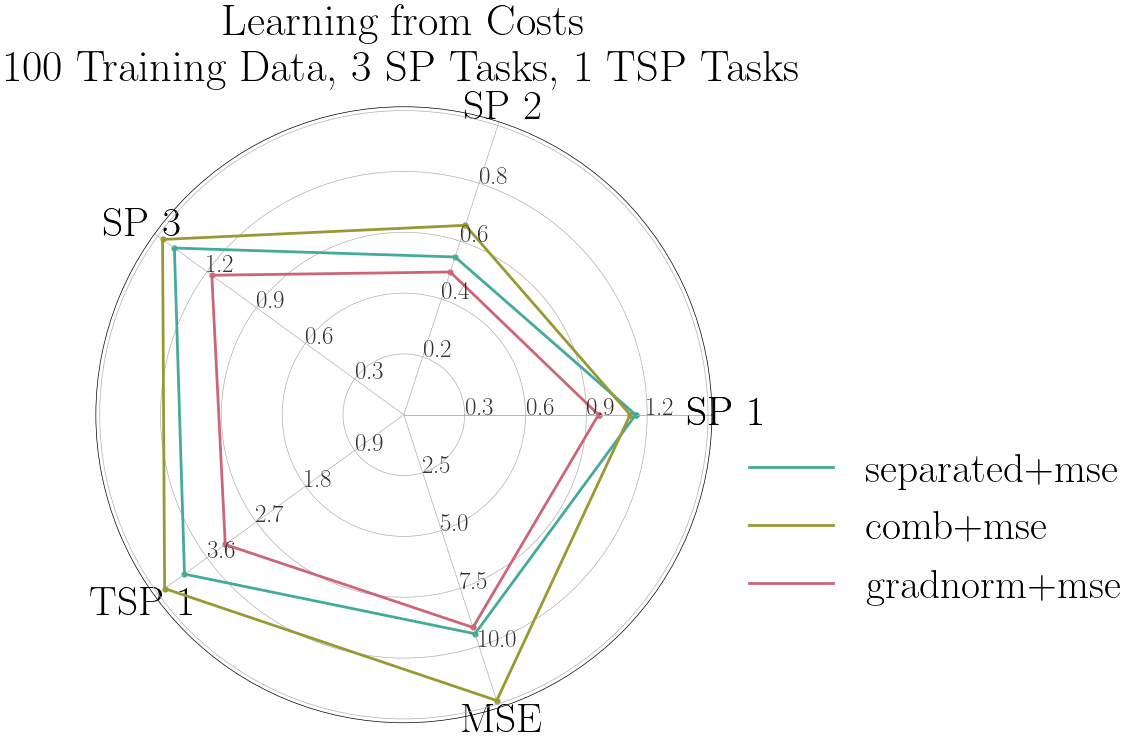

In [11]:
train_args["algo"] = "spo"
task_args["n_sp"] = 3
task_args["n_tsp"] = 1
data_args["data"] = 100
saveRadar(data_args, task_args, train_args, methods)

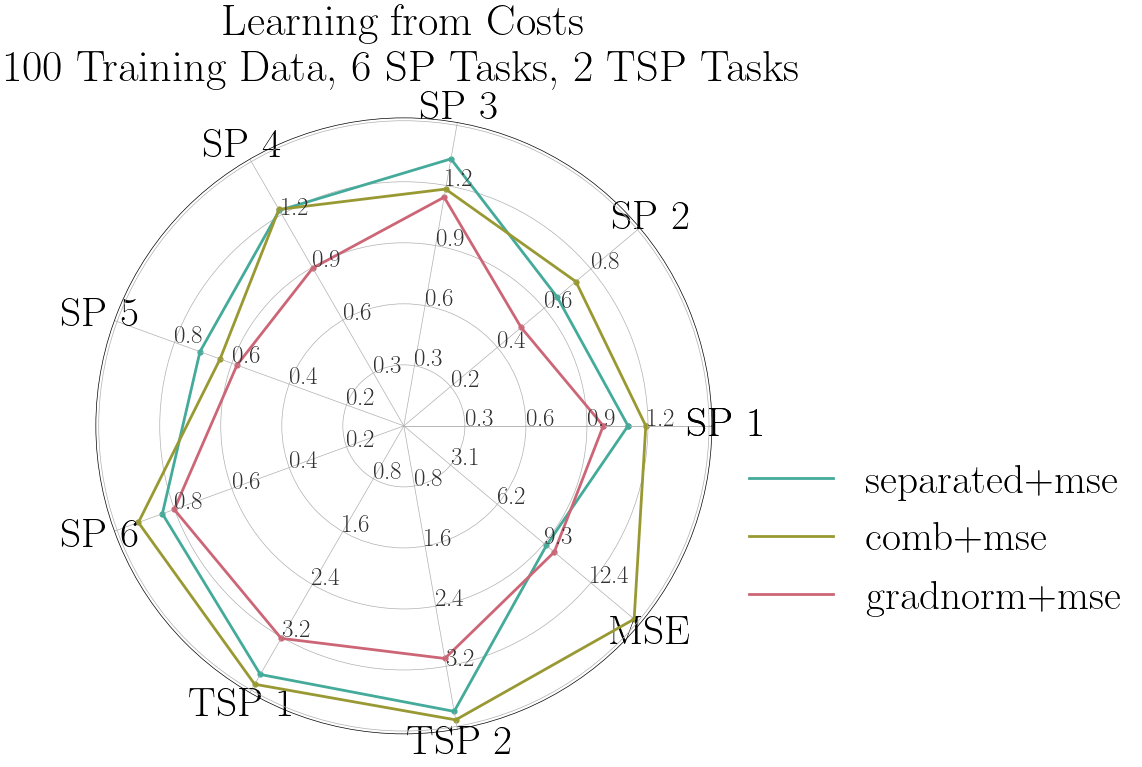

In [12]:
train_args["algo"] = "spo"
task_args["n_sp"] = 6
task_args["n_tsp"] = 2
data_args["data"] = 100
saveRadar(data_args, task_args, train_args, methods)

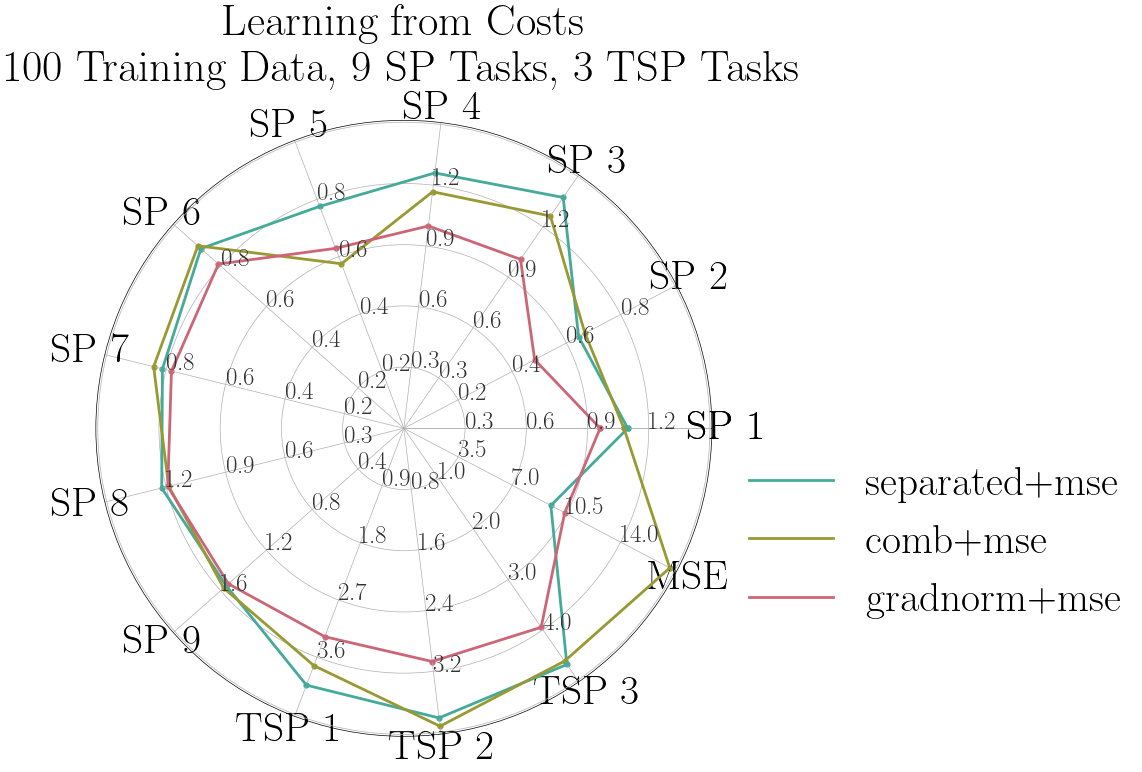

In [13]:
train_args["algo"] = "spo"
task_args["n_sp"] = 9
task_args["n_tsp"] = 3
data_args["data"] = 100
saveRadar(data_args, task_args, train_args, methods)

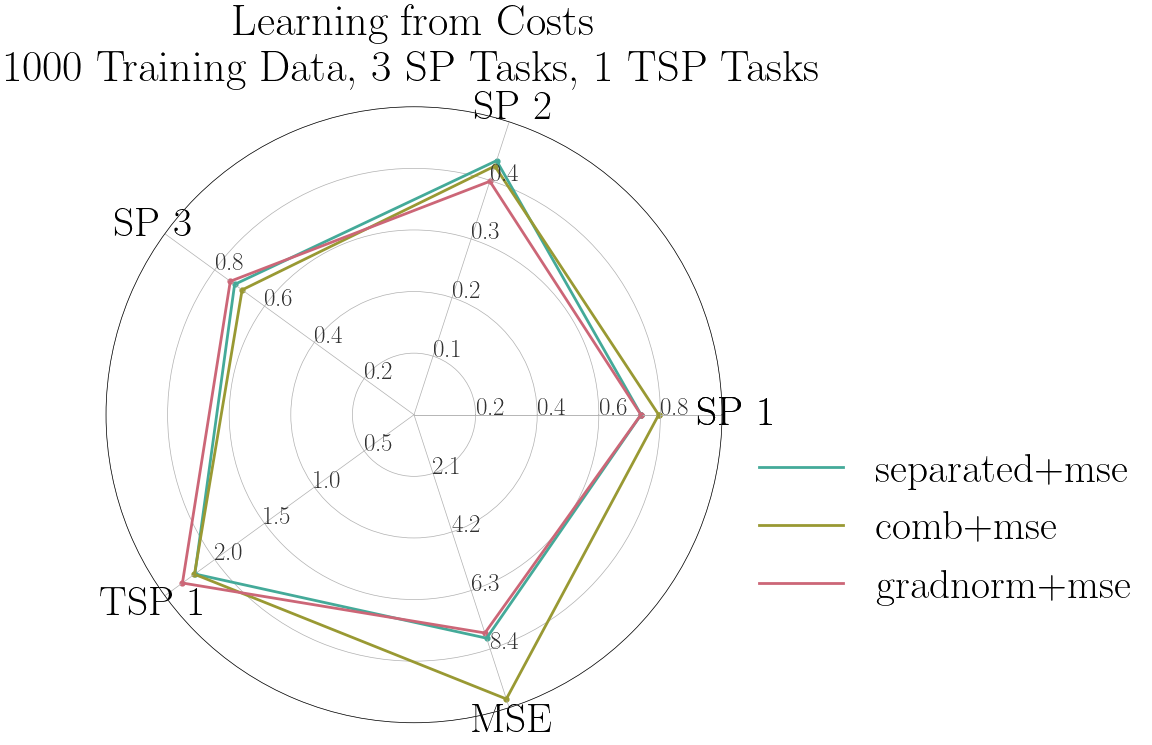

In [14]:
train_args["algo"] = "spo"
task_args["n_sp"] = 3
task_args["n_tsp"] = 1
data_args["data"] = 1000
saveRadar(data_args, task_args, train_args, methods)

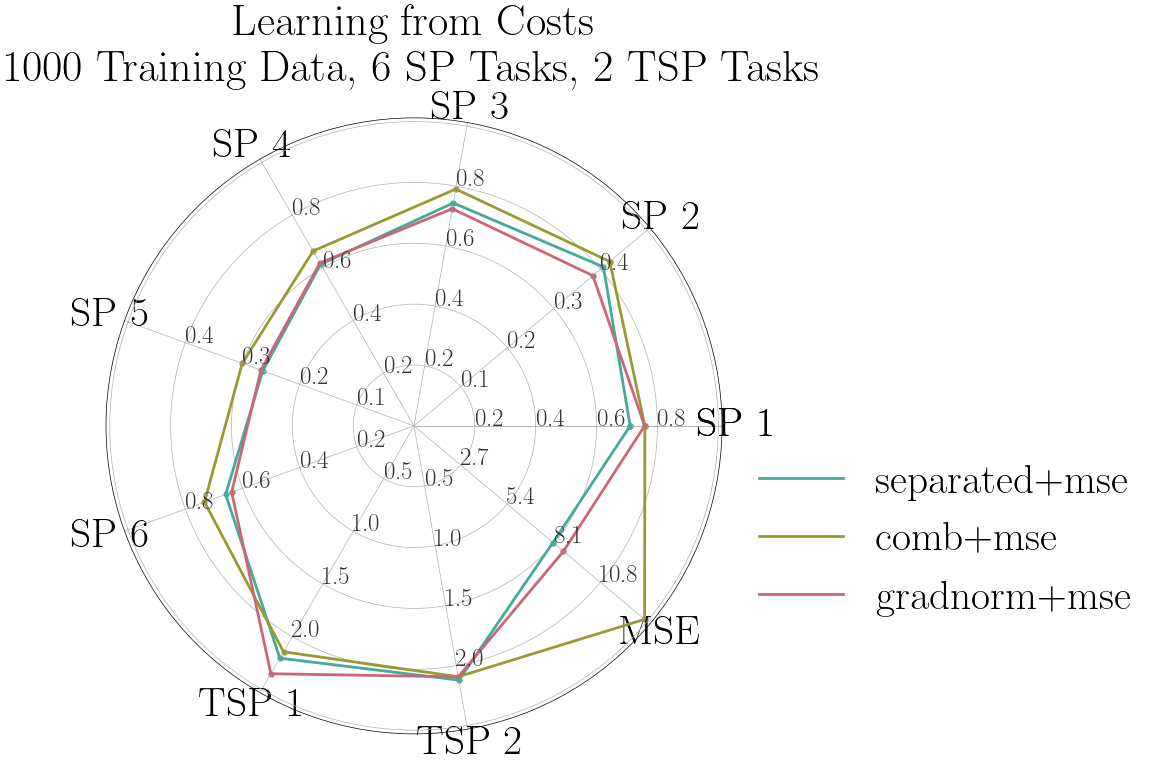

In [15]:
train_args["algo"] = "spo"
task_args["n_sp"] = 6
task_args["n_tsp"] = 2
data_args["data"] = 1000
saveRadar(data_args, task_args, train_args, methods)

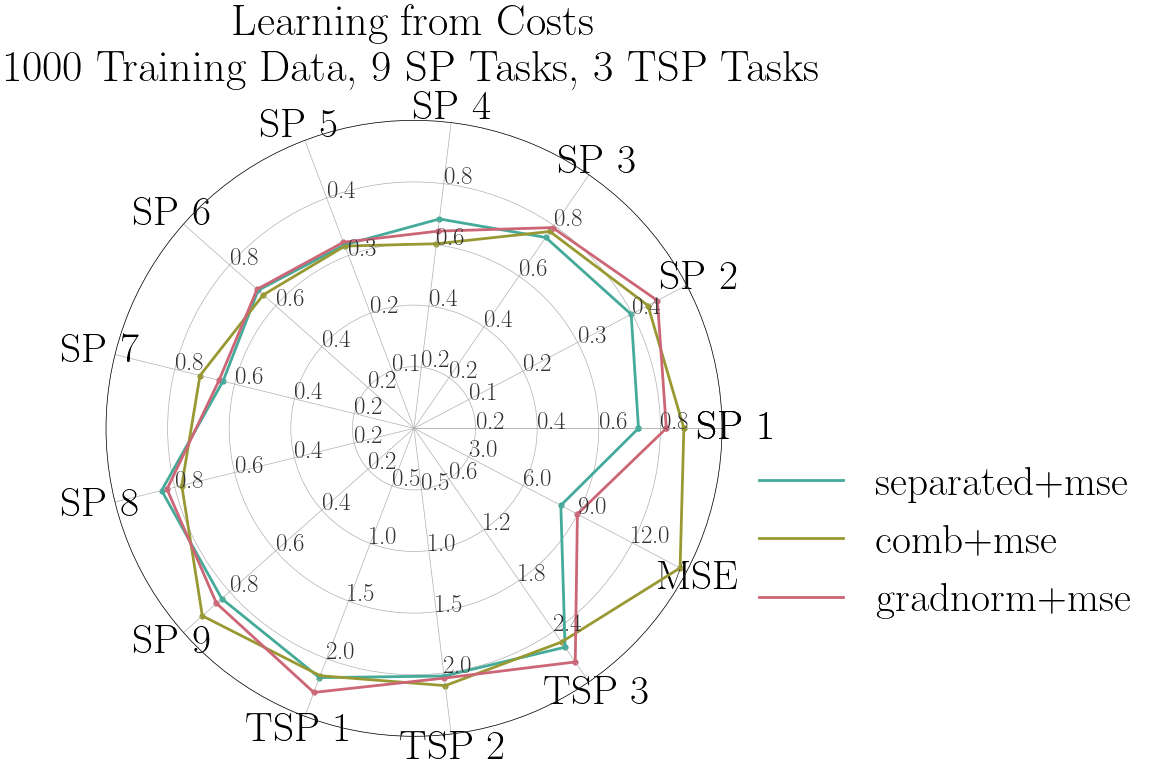

In [16]:
train_args["algo"] = "spo"
task_args["n_sp"] = 9
task_args["n_tsp"] = 3
data_args["data"] = 1000
saveRadar(data_args, task_args, train_args, methods)

## PFYL 

In [17]:
methods = ["separated", "comb", "gradnorm"]#, "scheduled"]

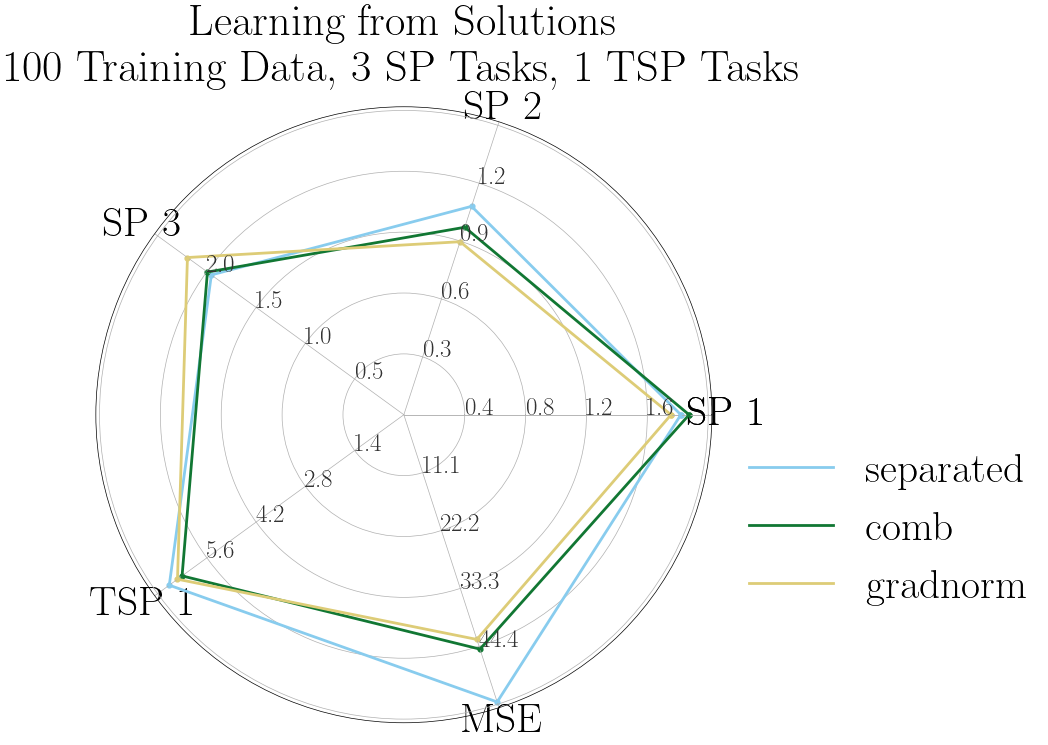

In [18]:
train_args["algo"] = "pfyl"
task_args["n_sp"] = 3
task_args["n_tsp"] = 1
data_args["data"] = 100
saveRadar(data_args, task_args, train_args, methods)

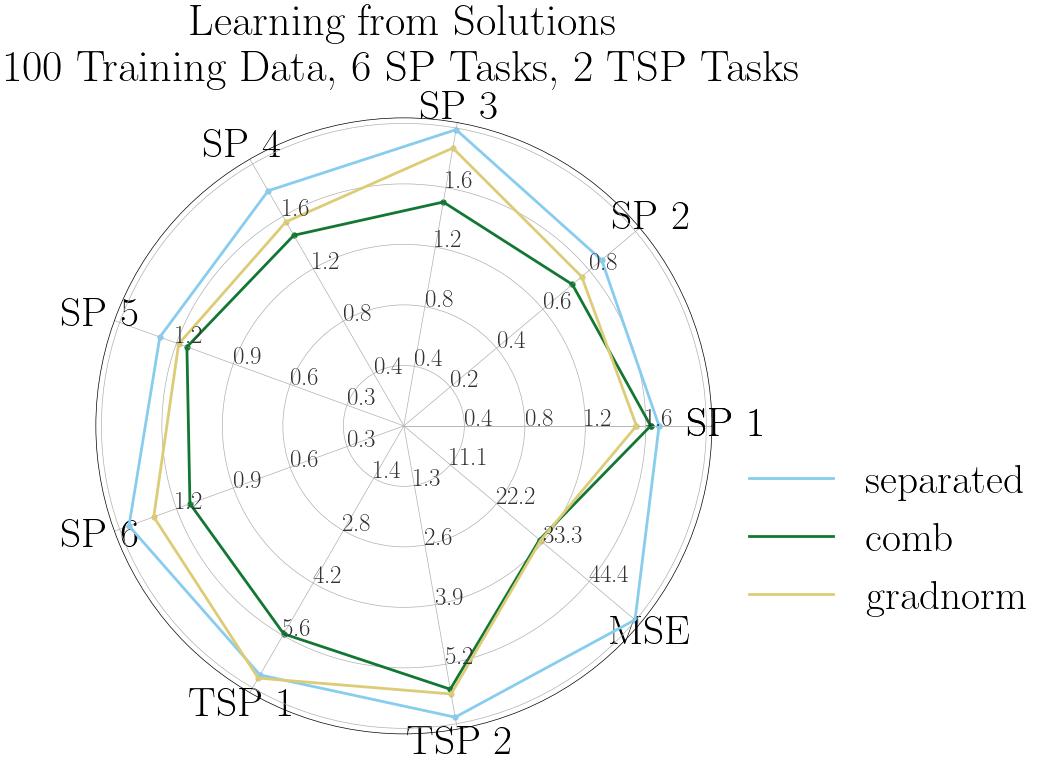

In [19]:
train_args["algo"] = "pfyl"
task_args["n_sp"] = 6
task_args["n_tsp"] = 2
data_args["data"] = 100
saveRadar(data_args, task_args, train_args, methods)

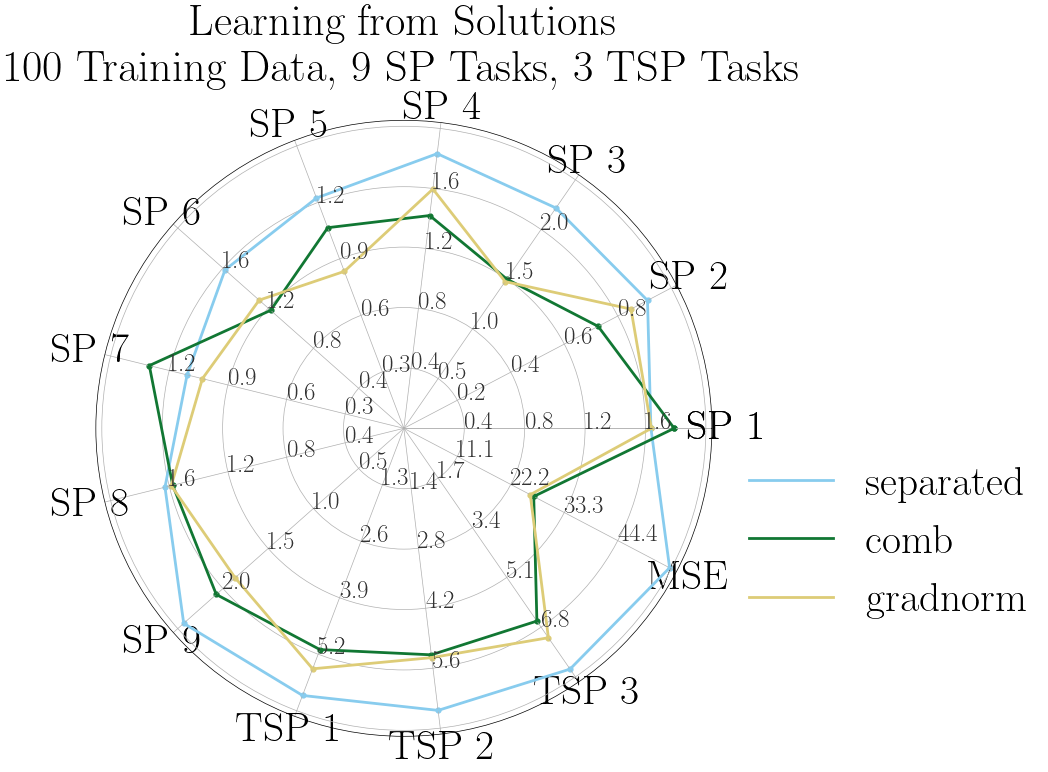

In [20]:
train_args["algo"] = "pfyl"
task_args["n_sp"] = 9
task_args["n_tsp"] = 3
data_args["data"] = 100
saveRadar(data_args, task_args, train_args, methods)

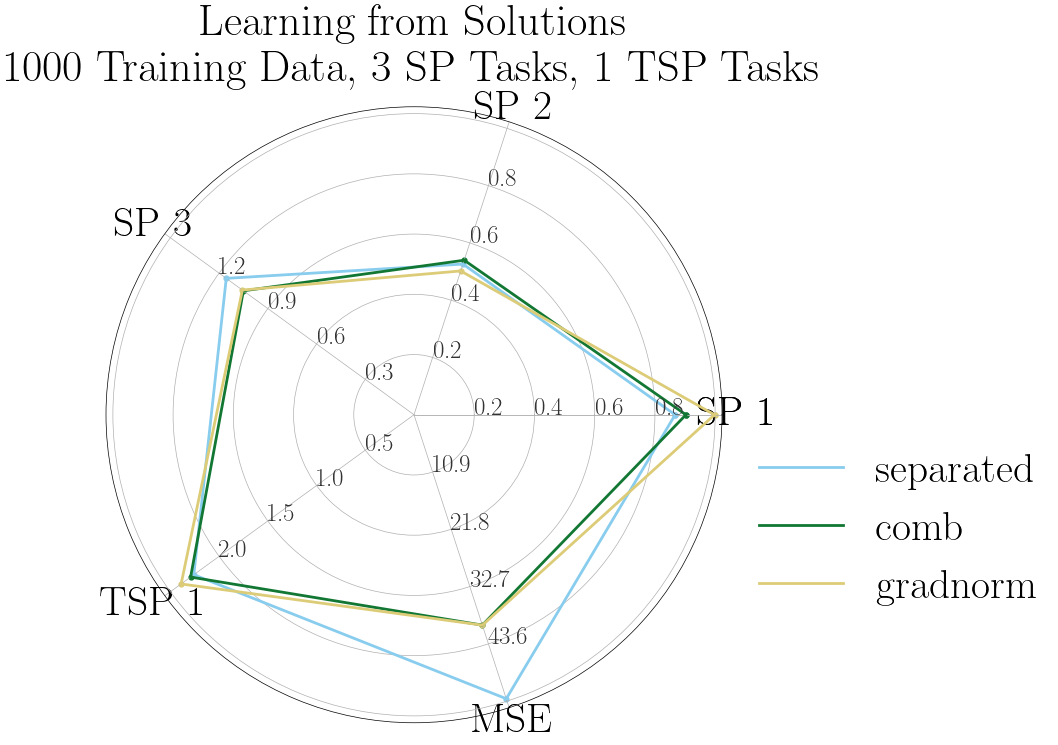

In [21]:
train_args["algo"] = "pfyl"
task_args["n_sp"] = 3
task_args["n_tsp"] = 1
data_args["data"] = 1000
saveRadar(data_args, task_args, train_args, methods)

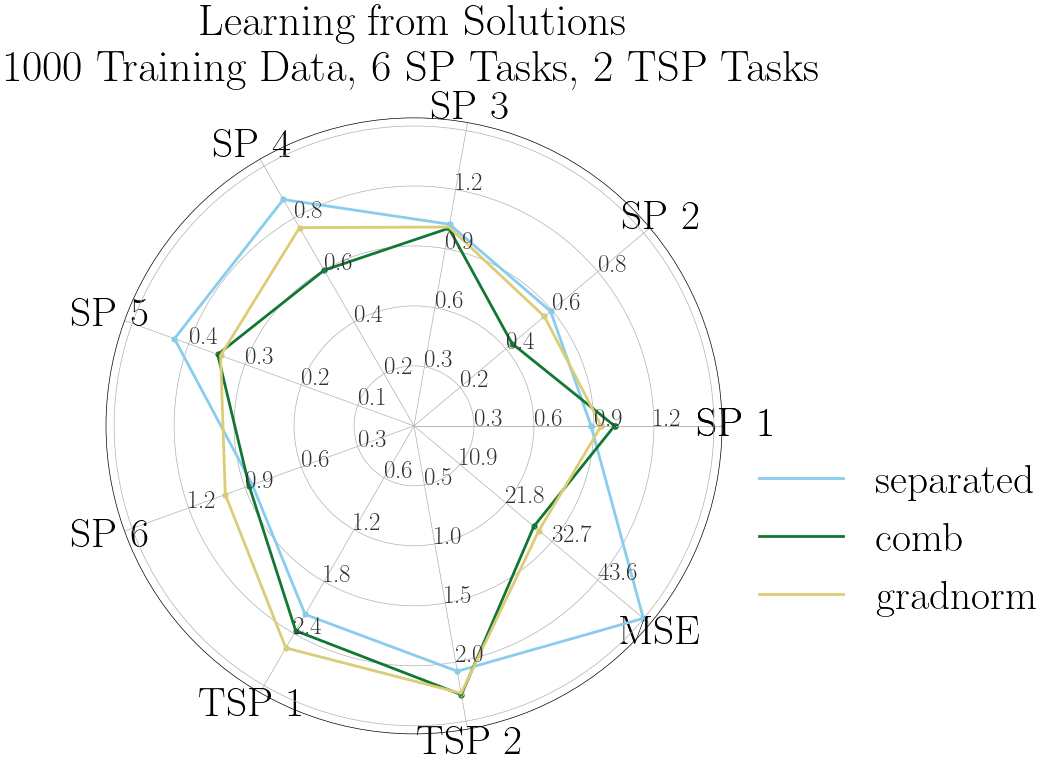

In [22]:
train_args["algo"] = "pfyl"
task_args["n_sp"] = 6
task_args["n_tsp"] = 2
data_args["data"] = 1000
saveRadar(data_args, task_args, train_args, methods)

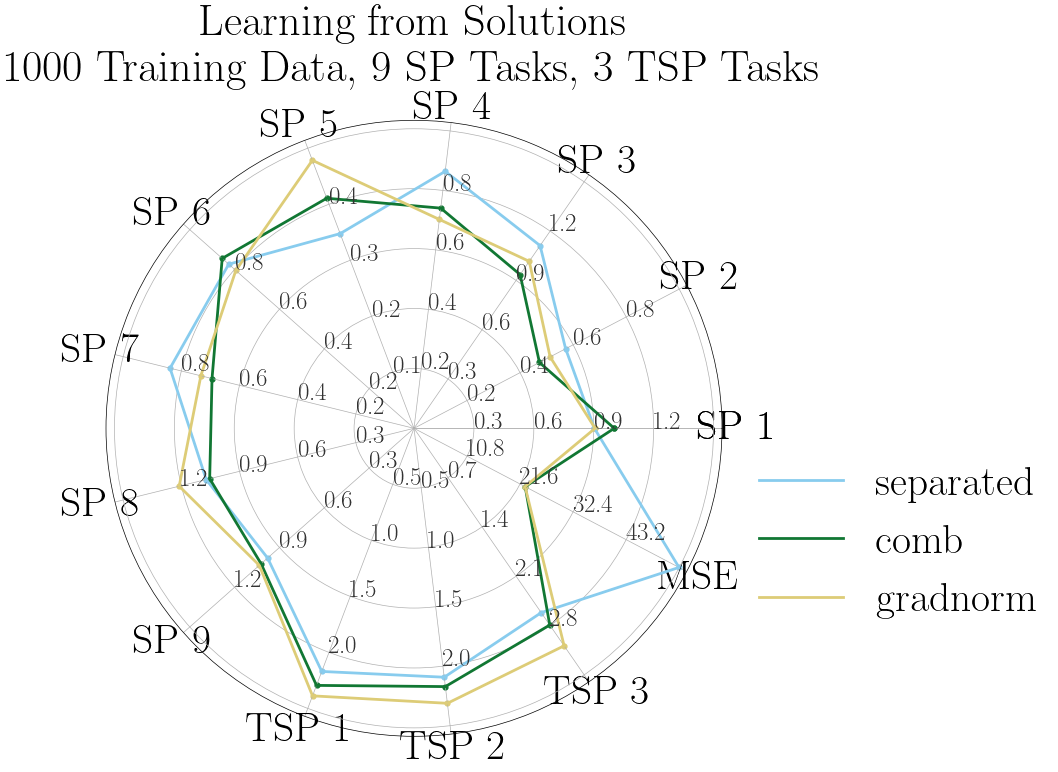

In [23]:
train_args["algo"] = "pfyl"
task_args["n_sp"] = 9
task_args["n_tsp"] = 3
data_args["data"] = 1000
saveRadar(data_args, task_args, train_args, methods)